<font size = "3">
QTM 151 Section 4
Group Member: Nate Hu, Max Jiang, Garry Zhu

Introduction (Background Analysis):

Undertsanding the Schema:

In this project, we analyze a comprehensive Formula 1 dataset, focusing on different levels of the competition, including circuit, race, driver, constructor, and status. The goal is to extract meaningful insights and patterns that can help us answer key questions about the sport, such as identifying the most successful drivers or constructors, understanding the impact of circuit characteristics on race outcomes, and assessing the factors that contribute to the overall performance of a driver or a team. The project is structured into different sections, each addressing a specific level of the competition. The results of our analysis will be presented in a clear and concise manner, supported by visualizations and data-driven conclusions that cater to both Formula 1 aficionados and novices alike.

Question:
- Examine the range of time the dataset contains
- Which Country have the most drivers?
- Which Country held the most races?
- What are some factors that is related to the success of the competition.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
import sqlalchemy as sa
from   sqlalchemy.engine import URL
from   sqlalchemy import text
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import squarify 
from   matplotlib import ticker

In [2]:
url_server = URL.create(
    "postgresql",
    host = 'localhost',
    database = 'postgres',
    username = 'postgres',
    port = 5432,
    password  = '')

con = sa.create_engine(url_server).connect()

In [15]:
circuits = pd.read_csv("data_raw/circuits.csv")
constructors_results = pd.read_csv("data_raw/constructor_results.csv")
constructors_standings = pd.read_csv("data_raw/constructor_standings.csv")
constructors = pd.read_csv("data_raw/constructors.csv")
driver_standing = pd.read_csv("data_raw/driver_standings.csv")
drivers = pd.read_csv("data_raw/drivers.csv")
lap_times = pd.read_csv("data_raw/lap_times.csv")
pit_stops = pd.read_csv("data_raw/pit_stops.csv")
qualifying = pd.read_csv("data_raw/qualifying.csv")
races = pd.read_csv("data_raw/races.csv")
driver_results = pd.read_csv("data_raw/results.csv")
seasons = pd.read_csv("data_raw/seasons.csv")
sprint_results = pd.read_csv("data_raw/sprint_results.csv")
status = pd.read_csv("data_raw/status.csv")

In [16]:
circuits.to_sql("circuits", con = con, if_exists='replace')
constructors_results.to_sql("constructor_results", con = con, if_exists='replace')
constructors.to_sql("constructors", con = con, if_exists='replace')
constructors_standings.to_sql("constructor_standings", con = con, if_exists='replace')
drivers.to_sql("drivers", con = con, if_exists='replace')
driver_standing.to_sql("driver_standings", con = con, if_exists='replace')
lap_times.to_sql("lap_times", con = con, if_exists='replace')
pit_stops.to_sql("pit_stops", con = con, if_exists='replace')
qualifying.to_sql("qualifying", con = con, if_exists='replace')
races.to_sql("races", con = con, if_exists='replace')
driver_results.to_sql("driver_results", con = con, if_exists='replace')
seasons.to_sql("seasons", con = con, if_exists='replace')
status.to_sql("status", con = con, if_exists='replace')

139

In [5]:
#First, Finding the range of time the datasets contains
pd.read_sql(text("SELECT MAX(year) AS last_year, MIN(year) AS first_year \
                FROM seasons;"),con)

,last_year,first_year
0,2023,1950


In [17]:
# Second, Data Cleaning and Merging
races_merge = pd.merge(races,
                       circuits,
                       on = "circuitId",
                       how = "left")
drivers_merge = pd.merge(drivers,
                         driver_results,
                         on='driverId',
                         how='left')
constructors_merge = pd.merge(constructors,
                              constructors_standings,
                              on = 'constructorId')
drivers_merge_2 = pd.merge(drivers,
                           driver_standing,
                           on = 'driverId',
                           how = 'left')

In [7]:
# Create a new column called full_name
drivers_merge['full_name']=drivers_merge['forename']+" "+drivers_merge['surname']

# Subset the merged dataset and group by driverId to sum the points earned of each driver
driver_points = (drivers_merge[['driverId', 'full_name','points',"nationality"]]
                 .groupby(['driverId','full_name','nationality'])
                 .agg(sum_points = ("points","sum")).reset_index())


# Sort the drivers by total points
driver_points_sorted = driver_points.sort_values(by='sum_points', ascending=False)

# Display the sorted driver points, top 100 drivers
top_100_drivers = driver_points_sorted.head(100)
top_100_drivers.head(5)

,driverId,full_name,nationality,sum_points
0,1,Lewis Hamilton,British,4396.5
19,20,Sebastian Vettel,German,3098.0
3,4,Fernando Alonso,Spanish,2061.0
828,830,Max Verstappen,Dutch,1983.5
7,8,Kimi Räikkönen,Finnish,1873.0


In [8]:
fig = px.histogram(top_100_drivers, x="nationality",title='Number of top 100 players per country', color='nationality')
fig.show()

[-54.529184790441136, 1.3489019690657706]


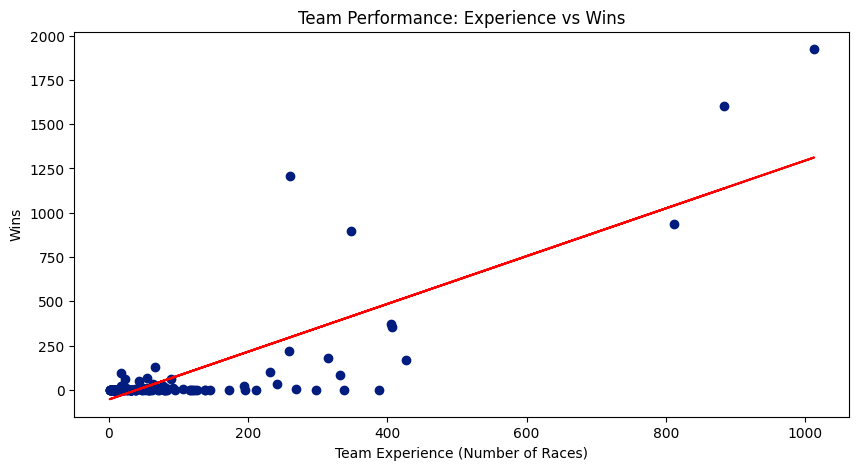

In [9]:
team_performance = (constructors_merge[['wins','constructorId']]
                    .groupby('constructorId')
                    .agg(sum_wins = ("wins","sum")).reset_index())

team_performance['team_experience'] = (constructors_merge[['raceId','constructorId']]
                                       .groupby('constructorId').nunique().values)

plt.style.use('seaborn-v0_8-dark-palette')
plt.figure(figsize=(10, 5))
#Create a scatter plot
plt.scatter(team_performance['team_experience'], team_performance['sum_wins'])
plt.xlabel('Team Experience (Number of Races)')
plt.ylabel('Wins')
plt.title('Team Performance: Experience vs Wins')

# Fit best-fit line using OLS regression
model = smf.ols(formula='sum_wins ~ team_experience', data=team_performance)
results = model.fit()

# Get estimated intercept and slope
b0, b1 = results.params
print([b0,b1])

# Add best-fit line to scatter plot
x = team_performance['team_experience']
y = b0 + b1 * x
plt.plot(x, y, color='red')
plt.show()

[-14.63306862695499, 0.6387982954781561]


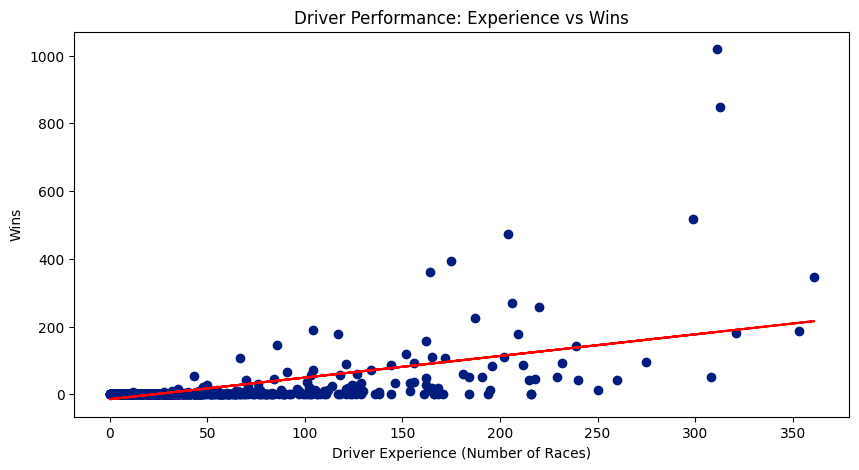

In [10]:
driver_performance = (drivers_merge_2[['wins','driverId']]
                    .groupby('driverId')
                    .agg(sum_wins = ("wins","sum"))
                    .reset_index())
driver_performance['driver_experience'] = (drivers_merge_2[['raceId','driverId']]
                                       .groupby('driverId').nunique().values)

plt.style.use('seaborn-v0_8-dark-palette')
plt.figure(figsize=(10, 5))
plt.scatter(driver_performance['driver_experience'], driver_performance['sum_wins'])
plt.xlabel('Driver Experience (Number of Races)')
plt.ylabel('Wins')
plt.title('Driver Performance: Experience vs Wins')

# Fit best-fit line using OLS regression
model = smf.ols(formula='sum_wins ~ driver_experience', data=driver_performance)
results = model.fit()

# Get estimated intercept and slope
b0, b1 = results.params
print([b0,b1])
# Add best-fit line to scatter plot
x = driver_performance['driver_experience']
y = b0 + b1 * x
plt.plot(x, y, color='red')
plt.show()

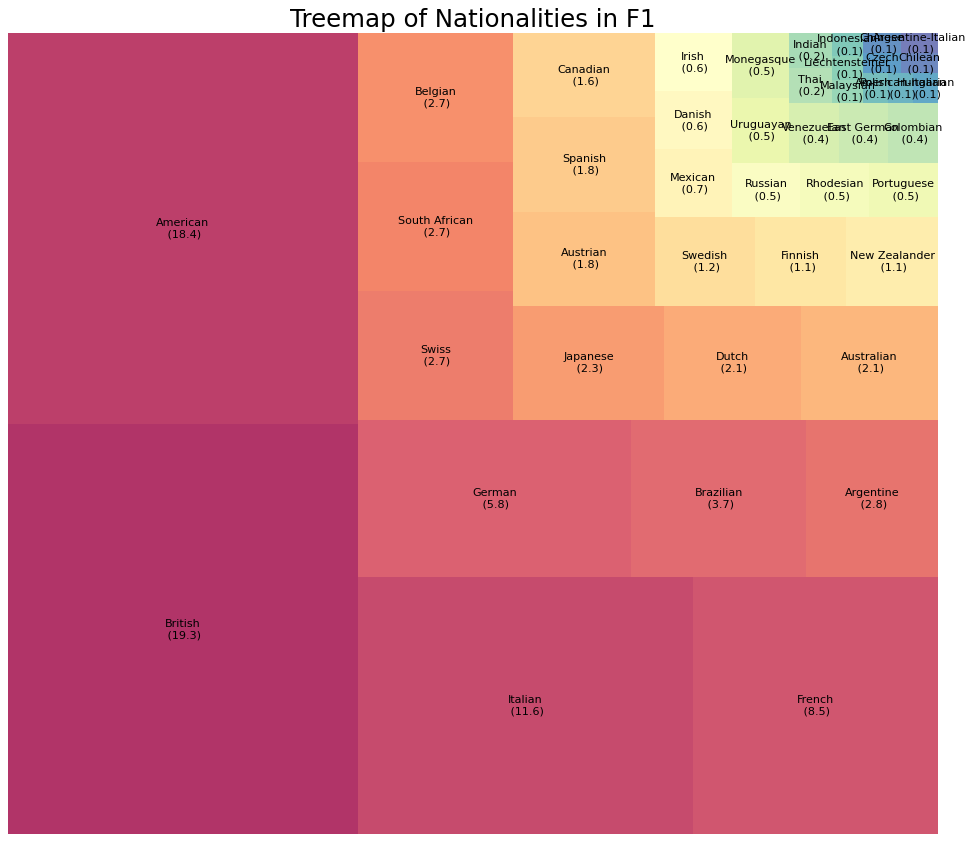

In [77]:
# Group the dataframe by nationality and count the number of occurrences
nationality_counts = drivers.groupby("nationality")["nationality"].count()

# Calculate the total number of drivers
total_drivers = nationality_counts.sum()

# Calculate the percentage of each nationality
nationality_percentages = nationality_counts / total_drivers * 100

# Create a pandas dataframe to store the nationality percentages
nationality_df = pd.DataFrame({"Nationality": nationality_percentages.index, "Percentage": nationality_percentages.values})

# Sort the dataframe by percentage in descending order
nationality_df = nationality_df.sort_values(by="Percentage", ascending=False)

# Format the percentage values in the dataframe to one decimal place
nationality_df["Percentage"] = nationality_df["Percentage"].apply(lambda x: round(x, 1))

# Create labels for the treemap
labels = nationality_df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)

# Create sizes and colors for the treemap
sizes = nationality_df['Percentage'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Create the treemap using Squarify
plt.figure(figsize=(15,13), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate the treemap
plt.title('Treemap of Nationalities in F1', fontsize=22)
plt.axis('off')
plt.show()


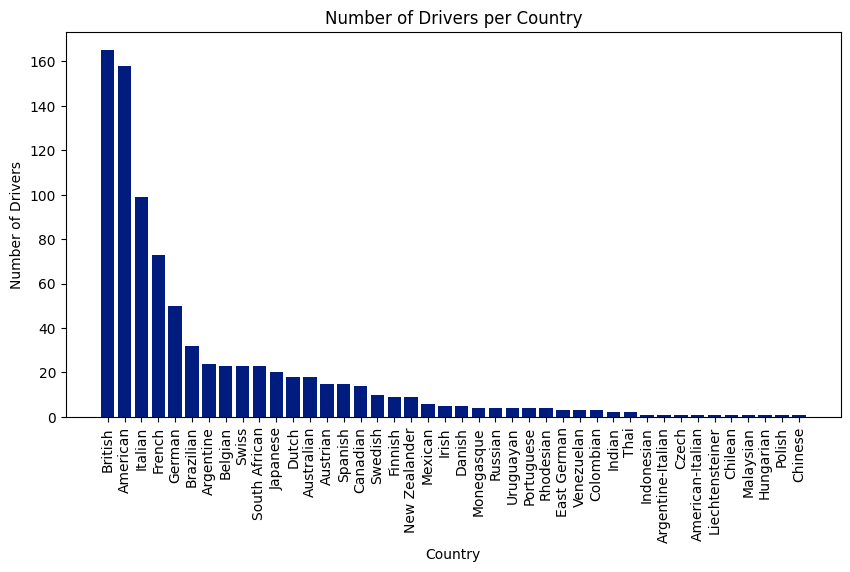

In [48]:
plt.style.use('seaborn-v0_8-dark-palette')
plt.figure(figsize=(10, 5))
plt.bar(driver_counts.index, driver_counts.values)
plt.xlabel("Country")
plt.ylabel("Number of Drivers")
plt.title("Number of Drivers per Country")
plt.xticks(rotation=90)
plt.show()

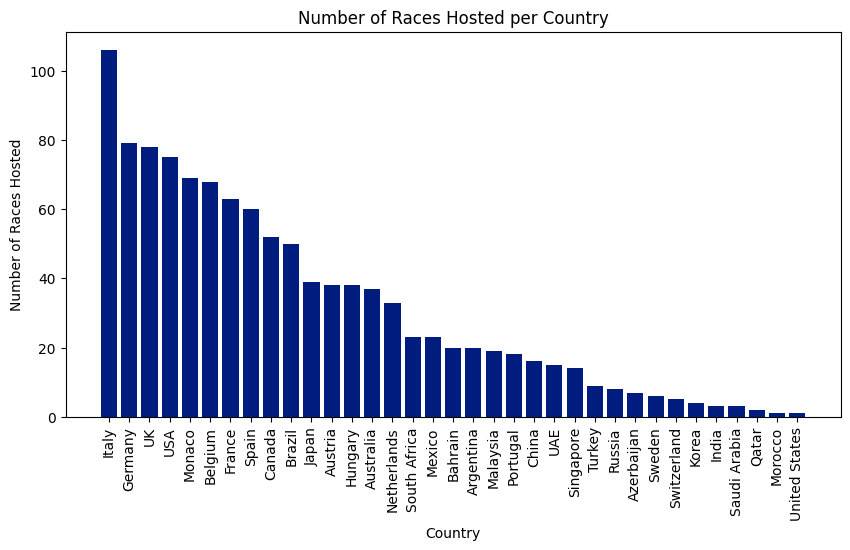

In [12]:
race_counts = races_merge["country"].value_counts()
plt.style.use('seaborn-v0_8-dark-palette')
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(race_counts.index, race_counts.values)
plt.xlabel("Country")
plt.ylabel("Number of Races Hosted")
plt.title("Number of Races Hosted per Country")
plt.xticks(rotation=90)
plt.show()

In [13]:
track_counts_1 =  pd.read_sql(text("SELECT location, COUNT(location) AS number_held, country \
                                    FROM circuits AS circ \
                                    JOIN races AS R \
                                    ON circ.\"circuitId\" = R.\"circuitId\" \
                                    GROUP BY location, country \
                                    ORDER BY number_held DESC \
                                    LIMIT 10;"), con)

fig = px.bar(track_counts_1, x='location', y='number_held', title='Number of races hosted per track', color='number_held')
fig.show()

<AxesSubplot: xlabel='grid', ylabel='rank'>

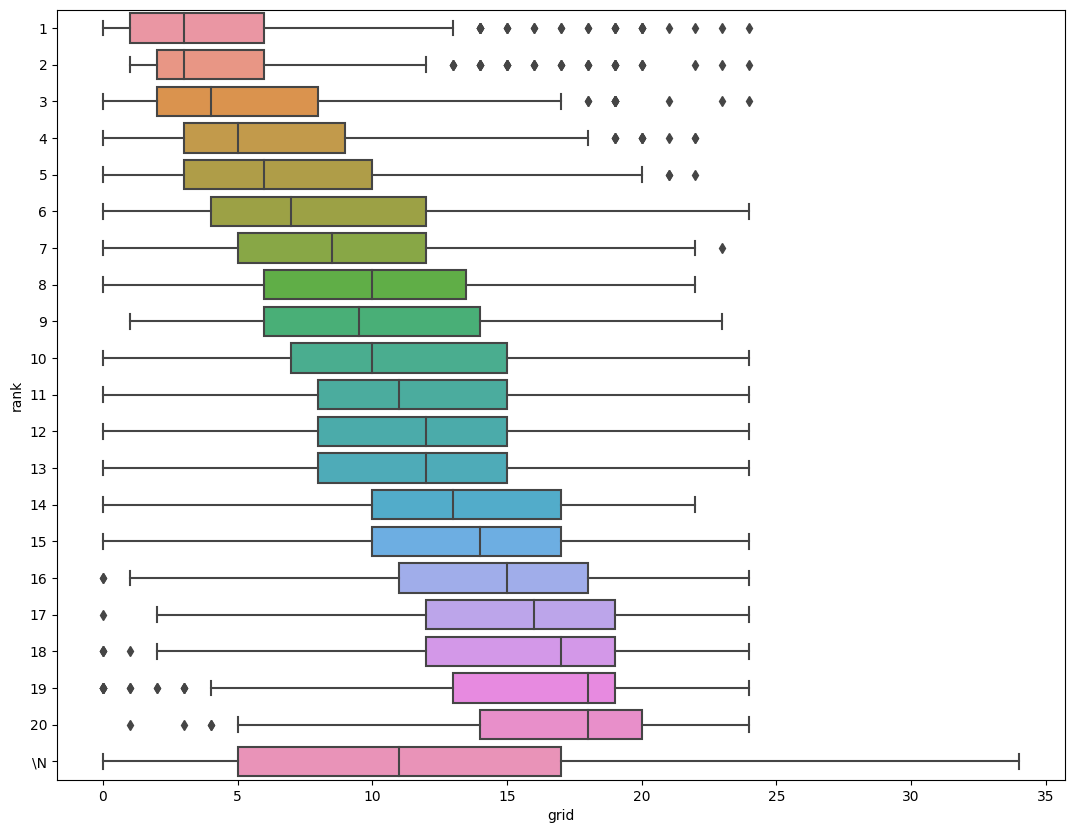

In [32]:
plt.figure(figsize=(13,10))
sns.boxplot(x='grid',
            y='rank',
            order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '20', '\\N'],
            data=driver_results, notch=False)